## Data Loading and Initial Inspection

In this section, we load the dataset and perform an initial inspection to understand its structure. The dataset contains tweets about various devices and the associated emotions directed at those devices. Our goal is to use this data for sentiment classification.

### Dataset Description:
The dataset consists of the following columns:
1. **text**: The content of the tweet.
2. **target_device**: The device or product the tweet is directed at (e.g., iPhone, iPad).
3. **emotion**: The sentiment expressed in the tweet, labeled as "Positive emotion", "Negative emotion", or "Neutral emotion".

### Steps:
1. **Load the dataset**: We load the dataset using pandas and check the first few rows to verify that the data has been loaded correctly.
2. **Renaming columns**: We rename the columns for easier handling.
3. **Explore basic statistics**: We will explore the structure and content of the dataset to understand its properties.


In [2]:
import pandas as pd

# data loading
file_url = 'https://raw.githubusercontent.com/George-Chira/twitter-sentiment-analysis/main/data/judge-1377884607_tweet_product_company.csv'
df = pd.read_csv(file_url, encoding='ISO-8859-1')

# Display the first few rows to verify
df.head()


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [3]:
# Renaming columns to shorter names
df_tweets = df.rename(columns={
    'tweet_text': 'text',
    'emotion_in_tweet_is_directed_at': 'target_device',
    'is_there_an_emotion_directed_at_a_brand_or_product': 'emotion'
})

# Verify the renaming
df_tweets.head(5)


,text,target_device,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [4]:
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           9092 non-null   object
 1   target_device  3291 non-null   object
 2   emotion        9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


check for missing values 

## Data Exploration

Before proceeding with data preprocessing and model building, it's essential to explore the dataset to understand its structure and content. This step helps identify missing data, analyze the distribution of sentiment labels, and inspect the raw text.

### Key Steps:
1. **Check for missing data**: We ensure there are no missing values in the key columns (`text`, `target_device`, and `emotion`).
2. **Examine the distribution of sentiment labels**: This will help us understand whether the data is balanced or imbalanced, which will influence the choice of modeling techniques and evaluation metrics.
3. **Sample inspection**: By reviewing a few sample tweets, we can plan the necessary text preprocessing steps (e.g., removing URLs, mentions, and hashtags).


In [5]:
# Check for missing values
print("Missing values before handling:\n", df_tweets.isnull().sum())

Missing values before handling:
 text                1
target_device    5802
emotion             0
dtype: int64


In [6]:
# Check for missing values
print(r"Missing values:\n", df_tweets.isnull().sum())

# Check distribution of sentiment labels
print(r" Distribution of sentiment labels:\n ", df_tweets['emotion'].value_counts())

# Display sample tweets
print(r" \n Sample tweets:\n", df_tweets['text'].head(5))

# Display sample tweets
print(r"\ntarget_device:\n", df_tweets['target_device'].head(5))

Missing values:\n text                1
target_device    5802
emotion             0
dtype: int64
 Distribution of sentiment labels:\n  emotion
No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: count, dtype: int64
 \n Sample tweets:\n 0    .@wesley83 I have a 3G iPhone. After 3 hrs twe...
1    @jessedee Know about @fludapp ? Awesome iPad/i...
2    @swonderlin Can not wait for #iPad 2 also. The...
3    @sxsw I hope this year's festival isn't as cra...
4    @sxtxstate great stuff on Fri #SXSW: Marissa M...
Name: text, dtype: object
\ntarget_device:\n 0                iPhone
1    iPad or iPhone App
2                  iPad
3    iPad or iPhone App
4                Google
Name: target_device, dtype: object


### Handling Missing Values

1. Any missing values in the **`target_device`** column are filled with the placeholder value **'Unknown'**. This ensures that missing device information does not result in the exclusion of otherwise useful data.

2. Any rows where the tweet **`text`**  is missing are dropped from the dataset. Tweets without content cannot be used for sentiment analysis.
After applying these steps, we verify that there are no missing values in the dataset.


In [7]:
#fill missing in the target devise with a placeholder "unknown"
df_tweets['target_device'].fillna('Unknown'  , inplace= True)
#drop missing values in text
df_tweets.dropna(subset=['text'], inplace=True)

#verify cleaning 
print("missing values after cleaning:", df_tweets.isna().sum())



missing values after cleaning: text             0
target_device    0
emotion          0
dtype: int64


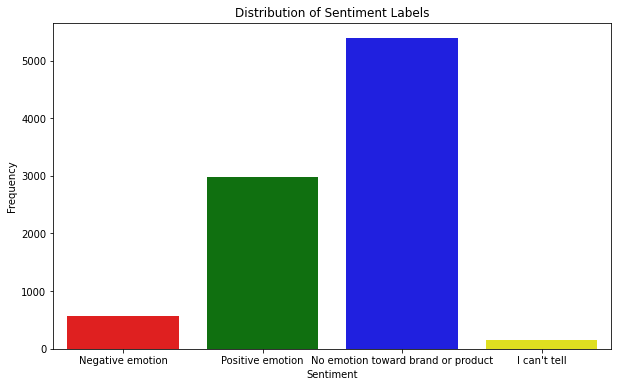

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

# Plot the distribution of sentiment labels
colors = ['red', 'green', 'blue', 'yellow']
sns.countplot(x='emotion', hue= 'emotion', palette = colors, data=df_tweets)
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
# Show the plots
plt.show()


## Data Preparation and Preprocessing

### Mapping Sentiment Labels to Categories

Before mapping the sentiment labels, we removed rows where the sentiment is labeled as **"I can't tell"** to focus on meaningful sentiment analysis. After removing these irrelevant rows, we map the remaining sentiment labels to numeric categories as follows:

- **"Negative emotion"** → **0**
- **"Neutral emotion"** → **1**
- **"Positive emotion"** → **2**
- **"No emotion toward brand or product"** → **1** (treated as **neutral**)

This mapping ensures that we account for all relevant sentiment categories, with **"No emotion"** treated as **neutral**, making the dataset ready for sentiment classification.

In [9]:
# Drop rows where the 'emotion' column contains 'I can't tell'
df_tweets = df_tweets[df_tweets['emotion'] != "I can't tell"]

# Map sentiment values to numeric categories, treating 'No emotion' as neutral (1)
sentiment_map = {
    'Negative emotion': 0,
    'Neutral emotion': 1,
    'Positive emotion': 2,
    'No emotion toward brand or product': 1  # Treat this as neutral
}

# Apply the mapping to the 'emotion' column
df_tweets['sentiment_numeric'] = df_tweets['emotion'].map(sentiment_map)

# Verify the changes and check the distribution of sentiment categories
df_tweets['sentiment_numeric'].value_counts()


sentiment_numeric
1    5388
2    2978
0     570
Name: count, dtype: int64

### Data Cleaning

In this step, we create a function to clean the raw text data to remove noise and prepare it for further processing. The following operations are performed:

1. **Remove URLs**: We remove any links in the tweet, as they don’t contribute to the sentiment analysis.
2. **Remove Mentions and Hashtags**: We eliminate mentions (`@username`) and hashtags (`#hashtag`) to focus only on the content of the tweet.
3. **Remove Special Characters and Numbers**: We remove any non-alphabetic characters, keeping only letters.
4. **Convert to Lowercase**: All text is converted to lowercase to avoid case sensitivity issues during modeling.

Once cleaned, the `text` column is transformed into a new column called `cleaned_text` for further processing.


In [10]:
import re
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Download necessary NLTK data files
nltk.download('stopwords')

# initializing the RegexpTokenizer, porterstemmer and stopwords
tokenizer = RegexpTokenizer(r"(?u)\w{3,}") #tokenizer that keeps 3 letter words
stopwords_list = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text, tokenizer, stopwords_list, stemmer):
    # Step 1: Remove URLs
    text = re.sub(r'http\S+|www\S+', " " , text)  # Removes any URL links starting with http or www
    # Step 2: Remove mentions and hashtags
    text = re.sub(r'@\w+|#\w+', " " , text) #remove usernames and hashtags 
    # Step 3: Remove special characters and numbers, keeping only alphabetic characters
    text = re.sub(r'[^a-zA-Z\s]', " " , text) #remove special characters retaing alphabet words only
    # Step 4: Standardize case (lowercase the text)
    text = text.lower()
    
    # Step 5: Tokenize ` Splits text into tokens (words) based on the tokenizer rules
    tokens = tokenizer.tokenize(text)  
    # Step 6: Remove stopwords using `stopwords_list`
    tokens = [word for word in tokens if word not in stopwords_list]  # Removes common stopwords
    # Step 7: Stem the tokenized text using `stemmer`
    tokens = [stemmer.stem(word) for word in tokens]  # Reduces words to their root form using stemming
    # Return the preprocessed text
    return tokens  # Returns the processed tokens (cleaned and stemmed)

# Apply function to the dataframe 
df_tweets['processed_tokens'] = df_tweets['text'].apply(lambda x: preprocess_text(x, tokenizer, stopwords_list, stemmer))
df_tweets[['text', 'processed_tokens']].head()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\GeorgeC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,processed_tokens
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,"[iphon, hr, tweet, dead, need, upgrad, plugin,..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,"[know, awesom, ipad, iphon, app, like, appreci..."
2,@swonderlin Can not wait for #iPad 2 also. The...,"[wait, also, sale]"
3,@sxsw I hope this year's festival isn't as cra...,"[hope, year, festiv, crashi, year, iphon, app]"
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,"[great, stuff, fri, marissa, mayer, googl, tim..."


### Feature Extraction with TF-IDF

After preprocessing the text, the next step is to convert the cleaned and tokenized text into numerical vectors a format that machine learning models can use for training and predictions.

#### Steps:
1.  We initialize the `TfidfVectorizer`, which transforms the processed tokens into numerical vectors.
2. **Fit and Transform**: We apply the vectorizer to the `processed_tokens` column to obtain the TF-IDF features.
3. **Result**: The resulting matrix represents the importance of each word across all tweets.

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert the processed tokens back into a single string for each tweet
df_tweets['processed_text'] = df_tweets['processed_tokens'].apply(lambda tokens: ' '.join(tokens))

# Initialize the TF-IDF Vectorizer 
tfidf = TfidfVectorizer()

# Fit and transform the 'processed_text' column into TF-IDF features
X = tfidf.fit_transform(df_tweets['processed_text'])

# Display shape of the resulting matrix
print(X.shape)



(8936, 5832)


## Modeling 
### Decision Tree Classifier: First Model

With the text data already transformed into numerical features using **TF-IDF**, we now move to building our first classification model: the **Decision Tree Classifier**.

#### Steps:
**Train-Test Split**: We split the dataset into training (80%) and test (20%) sets to train and evaluate the model.
**Training the Decision Tree**: We initialize the **Decision Tree Classifier** and train it using the training set.
**Prediction and Evaluation**:
   - After training, we make predictions on the test set.
   - The performance of the model is evaluated using **accuracy** and a **classification report**, which provides precision, recall, and F1-score for each sentiment category (Negative, Neutral, Positive).

This will provide a baseline performance of the Decision Tree model, which can be compared to other models in subsequent steps.


In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

#splitting the data into training and test sets
X = tfidf.fit_transform(df_tweets['processed_text'])  #tfidf features
y = df_tweets['emotion'] #target - positive, neutral, negative

#split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 42)

#initialize the tree classifier
tree = DecisionTreeClassifier( random_state= 42)

#model training
tree.fit(X_train, y_train)

#make predictions
y_pred = tree.predict(X_test)

#make evaluations
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))


Accuracy: 0.638940693770981
                                    precision    recall  f1-score   support

                  Negative emotion       0.40      0.26      0.32       189
No emotion toward brand or product       0.70      0.77      0.73      1612
                  Positive emotion       0.54      0.48      0.50       880

                          accuracy                           0.64      2681
                         macro avg       0.55      0.50      0.52      2681
                      weighted avg       0.63      0.64      0.63      2681



### Model Performance

The **Decision Tree Classifier** achieved an accuracy of **63.89%**. Performance for each sentiment class:

- **Negative emotion**: Precision of **0.40** and recall of **0.26**, resulting in an F1-score of **0.32**. The model struggles to identify negative emotions, missing many relevant samples.
  
- **Neutral emotion**: Precision of **0.70** and recall of **0.77**, with an F1-score of **0.73**. The model is highly effective at identifying neutral sentiments, likely due to their higher frequency in the dataset.

- **Positive emotion**: Precision of **0.54** and recall of **0.48**, leading to an F1-score of **0.50**. The model shows moderate performance in identifying positive emotions.


### Next Steps:
1. **Hyperparameter Tuning**: Further refine the model to boost performance.
2. **Handle Class Imbalance**: Implement strategies like `class_weight='balanced'` to improve results for minority classes.


best performers: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy after tuning and class weighting: 0.6199179410667661
                                    precision    recall  f1-score   support

                  Negative emotion       0.32      0.35      0.33       189
No emotion toward brand or product       0.72      0.70      0.71      1612
                  Positive emotion       0.52      0.53      0.52       880

                          accuracy                           0.62      2681
                         macro avg       0.52      0.53      0.52      2681
                      weighted avg       0.62      0.62      0.62      2681



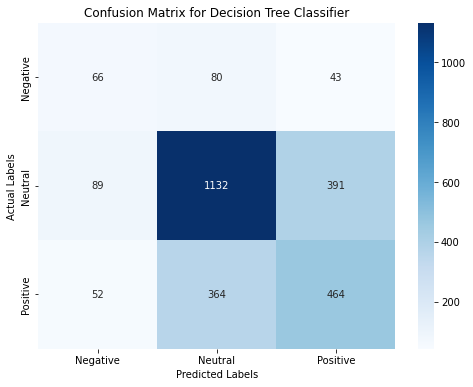

In [13]:
from sklearn.model_selection import GridSearchCV
#defining parameters
param_grid = {
    'max_depth': [5, 10, None],  
    'min_samples_split': [2, 10], 
    'min_samples_leaf': [1, 5], 
    'criterion': ['gini'], 
    'class_weight': [ 'balanced'] # Adding class_weight to deal with imbalance
    }

#initialize the gridsearch CV
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring = 'accuracy')

#fit the gridsearchCV on training data
grid_search.fit(X_train, y_train)

#get the best performers
print("best performers:", grid_search.best_params_)

#evaluate the best parameters
best_tree = grid_search.best_estimator_
y_pred_best = best_tree.predict(X_test)

# Print the new accuracy and classification report
print(f"Accuracy after tuning and class weighting: {accuracy_score(y_test, y_pred_best)}")
print(classification_report(y_test, y_pred_best)) 


# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_best, labels=['Negative emotion', 'No emotion toward brand or product', 'Positive emotion'])

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix for Decision Tree Classifier')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

### Hyperparameter Tuning Results with GridSearchCV

#### Performance After Tuning:
- **Negative emotion**: Precision improved to **0.32** (previous: 0.29), recall increased to **0.35** (previous: 0.26), and F1-score rose to **0.33** (previous: 0.29), showing better recognition of negative sentiments.
- **Neutral emotion**: Stable performance with an F1-score of **0.71** (previous: 0.73), indicating consistent identification of neutral sentiments.
- **Positive emotion**: Precision improved to **0.52** (previous: 0.50), with recall of **0.53** (previous: 0.48), resulting in an F1-score of **0.52** (previous: 0.50), showing slight improvement in identifying positive sentiments.



### Model 2: XGBoost (Extreme Gradient Boosting)

After evaluating the **Decision Tree** model, we observed that while it provided decent results, there are some limitations. 
#### Why XGBoost?
XGBoost is an advanced ensemble learning algorithm based on **Gradient Boosting**. It builds multiple decision trees sequentially, where each tree attempts to correct the errors of the previous one. This boosting technique helps the model generalize better and reduces overfitting, making XGBoost more powerful than a standard Decision Tree.

In the next step, we will build the XGBoost model using the same **TF-IDF features** that we used for the Decision Tree and evaluate its performance on the test set.


Accuracy: 0.6828859060402684
              precision    recall  f1-score   support

           0       0.53      0.13      0.21       126
           1       0.70      0.88      0.78      1094
           2       0.62      0.43      0.50       568

    accuracy                           0.68      1788
   macro avg       0.62      0.48      0.50      1788
weighted avg       0.67      0.68      0.65      1788



<Figure size 720x576 with 0 Axes>

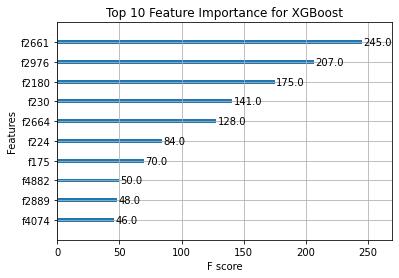

In [14]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

X = tfidf.fit_transform(df_tweets['processed_text'])
y = le.fit_transform(df_tweets['emotion'])

#perform test_train_split and flatten y_train and y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train XGBoost classifier
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb)}")
print(classification_report(y_test, y_pred_xgb))

# Plot feature importance for XGBoost
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Plot the top 10 important features
plt.figure(figsize=(10, 8))

plot_importance(xgb_model, max_num_features=10)
plt.title('Top 10 Feature Importance for XGBoost')
plt.show()


### XGBoost Model Performance

#### Performance After Training:
- **Negative emotion**: Precision improved to **0.53** (previous: 0.32), but recall dropped to **0.13** (previous: 0.35), resulting in an F1-score of **0.21** (previous: 0.33). While precision increased, recall for negative sentiment significantly worsened.
  
- **Neutral emotion**: Stable performance with an F1-score of **0.78** (previous: 0.71), with precision of **0.70** (previous: 0.72) and recall of **0.88** (previous: 0.70). The model improved its ability to correctly identify neutral sentiments.

- **Positive emotion**: Precision improved to **0.62** (previous: 0.52), though recall slightly decreased to **0.43** (previous: 0.53), resulting in an F1-score of **0.50** (previous: 0.52). Precision improved, but recall dropped slightly.

#### Summary:
- **Negative emotion** saw a trade-off: improved precision but a drop in recall, leading to a lower F1-score.
- **Neutral emotion** continued to perform well, with improved recall and stable precision.
- **Positive emotion** showed improved precision but a slight drop in recall, leading to a minor decline in F1-score.


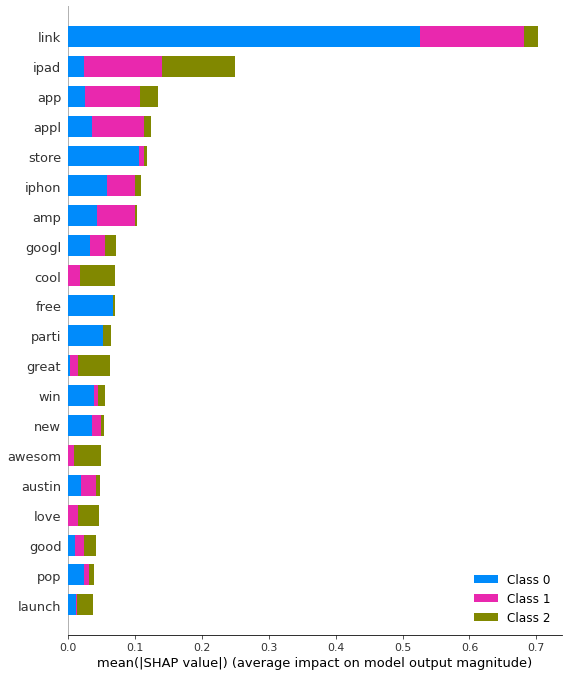

In [15]:
import shap

# Initialize SHAP explainer
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

# Plot SHAP summary (shows feature impact across the entire dataset)
shap.summary_plot(shap_values, X_test, feature_names=tfidf.get_feature_names_out())

#### Feature Importance Interpretation

The feature importance plot above shows the most influential words driving predictions across the three sentiment classes:

- **Class 0 (Negative)**: Words like "link", "amp", and "iphon" have a significant impact on negative sentiment predictions.
- **Class 1 (Neutral)**: Words such as "ipad", "app", and "store" influence predictions toward neutral sentiment.
- **Class 2 (Positive)**: Positive sentiment predictions are heavily influenced by words like "cool", "great", and "awesome."

The length of each bar represents the importance of the word in the prediction. Words like "ipad" and "app" show importance across multiple classes, indicating they contribute to predictions across different sentiments.


In [18]:
# Convert any non-string data in the 'text' column to strings
df_tweets['text'] = df_tweets['text'].astype(str)

# Now proceed with tokenization
encoded_input = tokenizer(
    df_tweets['text'].tolist(),  # Ensure the text is in list form
    padding=True,
    truncation=True,
    return_tensors='tf'
)


In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
import tensorflow as tf

# 1. Data Loading and Preprocessing
df_tweets = pd.read_csv('https://raw.githubusercontent.com/George-Chira/twitter-sentiment-analysis/main/data/judge-1377884607_tweet_product_company.csv', encoding='ISO-8859-1')

# Renaming columns
df_tweets = df_tweets.rename(columns={
    'tweet_text': 'text',
    'emotion_in_tweet_is_directed_at': 'target_device',
    'is_there_an_emotion_directed_at_a_brand_or_product': 'emotion'
})

# Drop rows where the sentiment is 'I can't tell'
df_tweets = df_tweets[df_tweets['emotion'] != "I can't tell"]

# Convert all text values to strings
df_tweets['text'] = df_tweets['text'].astype(str)

# 2. Mapping Sentiment Labels to Numeric Categories
sentiment_map = {
    'Negative emotion': 0,
    'Neutral emotion': 1,
    'Positive emotion': 2,
    'No emotion toward brand or product': 1  # Treat 'No emotion' as neutral
}
df_tweets['sentiment_numeric'] = df_tweets['emotion'].map(sentiment_map)

# Extract features and labels
X = df_tweets['text'].tolist()
y = df_tweets['sentiment_numeric'].values

# 3. Tokenization
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
encoded_input = tokenizer(
    X, padding=True, truncation=True, max_length=128, return_tensors='tf'
)

# Convert tensors to numpy arrays for compatibility with sklearn's train_test_split
input_ids = encoded_input['input_ids'].numpy()
attention_mask = encoded_input['attention_mask'].numpy()

# 4. Train-Test Split
X_train_ids, X_test_ids, X_train_mask, X_test_mask, y_train, y_test = train_test_split(
    input_ids, attention_mask, y, test_size=0.2, random_state=42
)

# 5. Initialize DistilBERT Model for Sequence Classification
num_labels = len(set(y))  # Number of unique sentiment classes
model = TFAutoModelForSequenceClassification.from_pretrained(
    'distilbert-base-uncased', num_labels=num_labels
)

# 6. Model Compilation
optimizer = Adam(learning_rate=5e-5)
loss = SparseCategoricalCrossentropy(from_logits=True)
metric = SparseCategoricalAccuracy()

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# 7. Model Training
history = model.fit(
    [X_train_ids, X_train_mask], y_train,
    epochs=2, batch_size=16,
    validation_data=([X_test_ids, X_test_mask], y_test)
)

# 8. Model Evaluation
loss, accuracy = model.evaluate([X_test_ids, X_test_mask], y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Predictions and Classification Report
y_pred_logits = model.predict([X_test_ids, X_test_mask]).logits
y_pred = tf.argmax(y_pred_logits, axis=1)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive']))


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/2


AttributeError: in user code:

    File "c:\Users\GeorgeC\anaconda3\envs\learn-env\lib\site-packages\keras\engine\training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\GeorgeC\anaconda3\envs\learn-env\lib\site-packages\keras\engine\training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\GeorgeC\anaconda3\envs\learn-env\lib\site-packages\keras\engine\training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\GeorgeC\anaconda3\envs\learn-env\lib\site-packages\transformers\modeling_tf_utils.py", line 1630, in train_step
        x, y, sample_weight = keras.utils.unpack_x_y_sample_weight(data)

    AttributeError: module 'keras.utils' has no attribute 'unpack_x_y_sample_weight'
